In [7]:
#coding=utf-8
import os
!python --version
!pwd
suffix=os.path.split(os.getcwd())[-1]
!ls -l test.dat.{suffix}
!ls -l train.dat.{suffix}
!wc -l test.dat.{suffix}
!wc -l train.dat.{suffix}
!head -n 1 train.dat.v23 |awk -F ',' '{print "train NF",NF}'
!head -n 1 test.dat.v23  | awk -F ',' '{print "test NF",NF}'
!ls

Python 3.7.5
/d/GH/GitWorkSpace/bank_model_competiton/data/v23
-rw-r--r-- 1 chenchen 197121 9001613 Aug 31 21:38 test.dat.v23
-rw-r--r-- 1 chenchen 197121 24230734 Aug 31 21:38 train.dat.v23
20055 test.dat.v23
53481 train.dat.v23
train NF 60
test NF 59
bak
model_gbdt_v23.ipynb
model_lgb_v23.ipynb
model_xgb_v23.ipynb
process_v23.ipynb
test.dat.v23
train.dat.v23


In [9]:
# -*- coding: utf-8 -*-
from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
import pandas as pd
import xgboost as xgb
import datetime
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
import sys
import os
import time 
import matplotlib.pyplot as plt 
import seaborn as sns
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import StratifiedKFold


suffix = os.path.split(os.getcwd())[-1]
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

train_dat_path = "train.dat.%s" % suffix 
test_dat_path = "test.dat.%s"  % suffix 
print(train_dat_path, test_dat_path, suffix)
print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

train.dat.v23 test.dat.v23 v23
process time :  2025-08-31 21:41:02


# 定义基础模型

In [6]:
def lgb_feature2(X_train, y_train, X_test, y_test, category_feature= []):
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = category_feature)
    lgb_test  = lgb.Dataset(X_test,  y_test,  categorical_feature = category_feature)
    eval_results = {}
    params = {
        'task':             'train',
        'boosting_type':    'gbdt',
        'objective':        'binary',
        'metric':           'auc',
        'num_leaves':       12,
        'learning_rate':    0.01,
        'feature_fraction': 0.65,
        'bagging_fraction': 0.65,
        'bagging_freq':     4,
        'min_data_in_leaf': 10,
        'max_depth':        5,
        'max_bin':          200,
        'verbose':          0,
    }
    eval_result = {}
    watchlist = [lgb_train , lgb_test]
    gbm = lgb.train(params, 
                    lgb_train, 
                    valid_sets = [lgb_train , lgb_test], 
                    num_boost_round = 2000,
                    callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=100)]
                    )                               
#     print('eval_results \n', eval_results)
    predict = gbm.predict(X_test)
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return gbm, vfunc(predict)

def stat_result(pp_ret):
    ret = pd.DataFrame({'label' : pp_ret})
    df_ret = ret.groupby(pd.cut(pp_ret, bins=20))['label'].agg('count')
    df_ret.plot(kind='bar')

<AxesSubplot:>

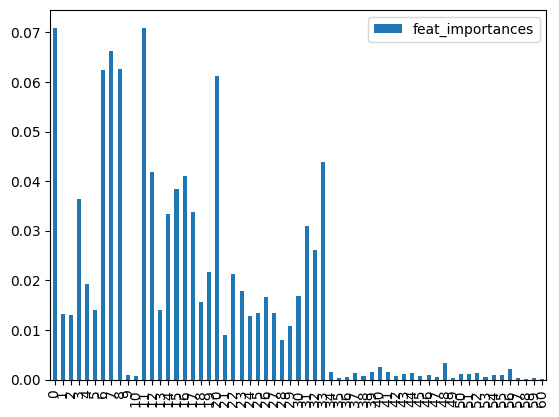

In [42]:
# plt.figure(figsize=(10, 6))
# sns.barplot(x='feat_importances', y='feat', data=df_fea_importance)
# plt.set_title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

# KFold 训练

In [ ]:
'id', 'title', 'career', 'zip_code', 'residence', 'loan', 'term',
       'interest_rate', 'issue_time', 'syndicated', 'installment',
       'record_time', 'history_time', 'total_accounts', 'balance_accounts',
       'balance_limit', 'balance', 'level', 'label', 'balance_account_avg',
       'loan_term_avg', 'balance_accounts_ratio', 'loan_log',
       'balance_account_avg_log', 'loan_term_avg_log',
       'balance_accounts_ratio_log', 'interest_rate_log', 'balance_log',
       'balance_limit_log', 'balance_accounts_log', 'zip_province', 'zip_city',
       'level_hash', 'level_ord', 'grade', 'interest_rate_cut',
       'interest_rate_log_cut', 'balance_cut', 'loan_cut', 'balance_limit_cut',
       'loan_term_avg_cut', 'balance_account_avg_cut', 'record_time_year',
       'record_time_month', 'record_time_week', 'record_time_year_month',
       'tx_max_min_days', 'tx_count', 'total_amount', '1_amount', '0_amount',
       'total_amount_avg', '1_amount_avg', '0_amount_avg', 'total_amount_avg2',
       '1_amount_avg2', '0_amount_avg2', 'tx_count_avg', 'tx_tmstp_max',
       'tx_tmstp_min'

In [17]:
dummy_fea=['id', 'level']

# 去掉
drop_fea = ['tx_time_max', 'tx_time_min', 'level_ord', 'loan_log',
       'balance_account_avg_log', 'loan_term_avg_log',
       'balance_accounts_ratio_log', 'interest_rate_log', 'balance_log',
       'balance_limit_log', 'balance_accounts_log', 'interest_rate_cut',
       'interest_rate_log_cut', 'balance_cut', 'loan_cut', 'balance_limit_cut',
       'loan_term_avg_cut', 'balance_account_avg_cut']

# drop_fea = ['tx_time_max', 'tx_time_min', 'level_ord']

train_data = pd.read_csv(train_dat_path, engine = 'python');
test_data  = pd.read_csv(test_dat_path,  engine = 'python');

train_test_data = pd.concat([train_data, test_data], axis=0, ignore_index = True)

for col_name in drop_fea : 
    if col_name in train_test_data.columns:
        train_test_data.drop([col_name], axis=1, inplace=True)
train_test_data = train_test_data.fillna(0)
train_test_data.replace([np.inf, -np.inf], 0, inplace=True)

dummy_df = pd.get_dummies(train_test_data.loc[:,dummy_fea])
train_test_data = pd.concat([train_test_data, dummy_df], axis=1)
train_test_data = train_test_data.drop(dummy_fea, axis=1)


train_train = train_test_data.iloc[:train_data.shape[0],:]
test_test = train_test_data.iloc[train_data.shape[0]:,:]

y_train_train = train_train['label'].values
X_train_train = train_train.drop(['label'], axis=1)
y_test_test  = test_test['label'].values
X_test_test  = test_test.drop(['label'], axis=1)
print('X_train_train \n', X_train_train.shape)
print('X_test_test \n', X_test_test.shape)
train_test_data

X_train_train 
 (53480, 68)
X_test_test 
 (20054, 68)


,title,career,zip_code,residence,loan,term,interest_rate,issue_time,syndicated,installment,record_time,history_time,total_accounts,balance_accounts,balance_limit,balance,label,balance_account_avg,loan_term_avg,balance_accounts_ratio,zip_province,zip_city,level_hash,grade,record_time_year,record_time_month,record_time_week,record_time_year_month,tx_max_min_days,tx_count,total_amount,1_amount,0_amount,total_amount_avg,1_amount_avg,0_amount_avg,total_amount_avg2,1_amount_avg2,0_amount_avg2,tx_count_avg,tx_tmstp_max,tx_tmstp_min,level_A0,level_A1,level_A2,level_A3,level_A4,level_A5,level_B0,level_B1,level_B2,level_B3,level_B4,level_B5,level_C1,level_C2,level_C3,level_C4,level_C5,level_D1,level_D2,level_D3,level_D4,level_D5,level_E1,level_E2,level_E3,level_E4,level_E5
0,9,0.0,221373,1,7200,36,10.95,1238631967,0,1,1238630622,472006661,17.0,9.0,36200.0,13856.00,0.0,1539.555556,200.000000,0.529412,22,2213,785,1,2009,4,14,200904,163.0,48.0,71787.0,12079.50,59707.50,440.411043,74.107362,366.303681,1495.562500,251.656250,1243.906250,0.294479,1.238198e+09,1.224115e+09,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,10.0,311681,0,21300,36,12.95,1128212052,0,0,1161907665,763779041,17.0,9.0,20400.0,13773.00,1.0,1530.333333,591.666667,0.529412,31,3116,677,2,2006,10,43,200610,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,8,7.0,271562,1,10400,60,21.05,1249171509,0,0,1383958593,727143443,17.0,9.0,10800.0,2023.00,0.0,224.777778,173.333333,0.529412,27,2715,560,2,2013,11,45,201311,180.0,48.0,22406.1,15883.72,6522.38,124.478333,88.242889,36.235444,466.793750,330.910833,135.882917,0.266667,1.383955e+09,1.368403e+09,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,7,2.0,522083,0,33050,36,16.40,1172882234,0,1,1214353935,687660346,17.0,9.0,24700.0,21992.00,0.0,2443.555556,918.055556,0.529412,52,5220,24,2,2008,6,26,200806,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8,3.0,101026,1,5200,36,14.35,1172882384,0,0,1240274527,322012875,17.0,9.0,5100.0,1669.00,1.0,185.444444,144.444444,0.529412,10,1010,710,2,2009,4,17,200904,169.0,93.0,51163.0,30823.10,20339.90,302.739645,182.385207,120.354438,550.139785,331.431183,218.708602,0.550296,1.238285e+09,1.223683e+09,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73529,0,8.0,601107,1,10000,12,18.85,1130976000,0,0,1125964800,1018224000,6.0,3.0,3818.0,2224.69,0.0,741.563333,833.333333,0.500000,60,6011,785,1,2005,9,36,200509,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73530,0,10.0,601102,1,10000,12,29.30,1156204800,0,0,1157068800,1054425600,6.0,6.0,5502.0,4126.71,0.0,687.785000,833.333333,1.000000,60,6011,560,2,2006,9,35,200609,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73531,0,4.0,601408,1,11000,12,24.75,1144108800,0,0,1111622400,1037404800,8.0,3.0,4844.0,2710.96,0.0,903.653333,916.666667,0.375000,60,6014,143,1,2005,3,12,200503,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73532,0,3.0,601904,1,8000,12,22.00,1163808000,0,0,1116892800,1057017600,6.0,3.0,3495.0,1834.93,0.0,611.643333,666.666667,0.500000,60,6019,143,1,2005,5,21,200505,0.0,0.0,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0

# LGB model1 SKfold

In [18]:
def lgb_feature(X_train, y_train, X_test, y_test, category_feature= []):
    lgb_train = lgb.Dataset(X_train, y_train,categorical_feature = category_feature)
    lgb_test = lgb.Dataset(X_test,   y_test, categorical_feature = category_feature)
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric':'auc',
        'num_leaves': 25,
        'learning_rate': 0.01,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_data_in_leaf':5,
        'max_bin':200,
        'verbose': 0,
    }
    watchlist = [lgb_train , lgb_test]
    gbm = lgb.train(params,lgb_train,
                    valid_sets = [lgb_train , lgb_test], 
                    num_boost_round=1000,
                   callbacks = [log_evaluation(period=100)])
    predict = gbm.predict(X_test)
    minmin = min(predict)
    maxmax = max(predict)
    vfunc = np.vectorize(lambda x:(x-minmin)/(maxmax-minmin))
    return gbm, vfunc(predict)

# -------------------------------------------------------- #

n_folds = 10
answers = []
models  = []
auc_arr = [] 

SEED = 10
sk = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
y_train_train = pd.DataFrame(y_train_train)
for i,(train,test) in enumerate(sk.split(X_train_train, y_train_train)):
    X_train = X_train_train.iloc[train]
    y_train = y_train_train.iloc[train]
    X_test  = X_train_train.iloc[test]
    y_test  = y_train_train.iloc[test]
    lgb_clf, test_pred = lgb_feature(X_train, y_train, X_test, y_test)
    models.append(lgb_clf)
    train_pred = lgb_clf.predict(X_train)
    # 记录训练集auc, 测试集auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('--------------the %d epoch lgb_model valid auc ------------- ' % i, train_auc, test_auc)
    auc_arr.append((train_auc,test_auc))
    #最终输出
    final_pred = lgb_clf.predict(X_test_test)
    print('final pred \n', final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr))
print('auc arr describe \n', pd.DataFrame(auc_arr).describe())

# print('# --------------------------- retrain ------------------------------------ #')
# lgb_lgb_clf, test_test_pred = lgb_feature(X_train_train, y_train_train, X_test_test, y_test_test)
print('process time : ',time.strftime( '%Y-%m-%d %H:%M:%S', time.localtime()))

[100]	training's auc: 0.679228	valid_1's auc: 0.657224
[200]	training's auc: 0.695546	valid_1's auc: 0.658454
[300]	training's auc: 0.70871	valid_1's auc: 0.661286
[400]	training's auc: 0.723067	valid_1's auc: 0.662835
[500]	training's auc: 0.735857	valid_1's auc: 0.663186
[600]	training's auc: 0.74776	valid_1's auc: 0.663285
[700]	training's auc: 0.75892	valid_1's auc: 0.663196
[800]	training's auc: 0.770189	valid_1's auc: 0.663445
[900]	training's auc: 0.779446	valid_1's auc: 0.66432
[1000]	training's auc: 0.789311	valid_1's auc: 0.66487
--------------the 0 epoch lgb_model valid auc -------------  0.7893114254357827 0.6648704174869071
final pred 
 [0.08525884 0.04039343 0.13344507 ... 0.19931598 0.19236882 0.204186  ]
[100]	training's auc: 0.67831	valid_1's auc: 0.659322
[200]	training's auc: 0.694506	valid_1's auc: 0.665306
[300]	training's auc: 0.710143	valid_1's auc: 0.665557
[400]	training's auc: 0.7232	valid_1's auc: 0.664931
[500]	training's auc: 0.737201	valid_1's auc: 0.66589

# 保存结果

In [21]:
def save_result(df_ans, fout_name):
    #保存结果
    df_ans['label'] = df_ans.mean(axis = 1)
    df_ans['id'] = pd.DataFrame({'id':X_test_test.index.values})[['id']]
    print('df_ans \n',df_ans)
    df_out = df_ans[['id','label']]
    print('df_out \n',df_out)
    df_out.to_csv('%s.csv' % fout_name, encoding='utf-8', index=False, mode='w')
    df_ans.to_csv('%s_ans.txt' % fout_name, encoding='utf-8', index=False, mode='w')
    df_ret.to_csv('%s_ret.txt' % fout_name, encoding='utf-8', index=False, mode='w')
    !ls

# -------------------------------------------------------------- #

df_ret = pd.DataFrame(answers).T
print('df_ret \n',df_ret)
df_ans = df_ret.loc[:, :]
save_result(df_ans, '%s_gh_lgb_10folds_mean_v23' % suffix)

df_ret 
               0         1         2         3         4         5         6  \
0      0.085259  0.110634  0.117442  0.092115  0.103316  0.107331  0.109064   
1      0.040393  0.042583  0.046514  0.044229  0.044535  0.039951  0.041874   
2      0.133445  0.116952  0.146966  0.161797  0.126523  0.107135  0.135865   
3      0.234347  0.226882  0.226697  0.239089  0.211855  0.220506  0.228315   
4      0.113947  0.112256  0.111246  0.122076  0.125132  0.106414  0.127198   
...         ...       ...       ...       ...       ...       ...       ...   
20049  0.207300  0.187192  0.191161  0.201292  0.186531  0.191221  0.195009   
20050  0.100706  0.093844  0.106330  0.106629  0.099447  0.101003  0.103918   
20051  0.199316  0.197881  0.188556  0.203644  0.199068  0.194911  0.182004   
20052  0.192369  0.179890  0.178099  0.179589  0.183908  0.177898  0.186312   
20053  0.204186  0.206589  0.200489  0.199859  0.196001  0.207589  0.201647   

              7         8         9  
0   

# 特征重要性分析

In [13]:
# 
idx = 1
df_imp = pd.DataFrame([models[idx].feature_name(), models[idx].feature_importance(), models[idx].feature_importance(importance_type='gain')]).T
df_imp.sort_values(by=2, ascending=False)

# 重训模型
# df_imp = pd.DataFrame([lgb_lgb_clf.feature_name(), lgb_lgb_clf.feature_importance(), lgb_lgb_clf.feature_importance(importance_type='gain')]).T
# df_imp.sort_values(by=2,ascending=False)

,0,1,2
6,interest_rate,1731,28519.304813
5,term,169,16717.467864
7,issue_time,1436,15075.375448
37,0_amount_avg2,574,14699.597496
14,balance_limit,1040,13636.567443
13,balance_accounts,693,12821.647072
10,record_time,845,11451.454028
11,history_time,1174,10640.452235
35,total_amount_avg2,674,10404.792402
2,zip_code,1033,10153.87893


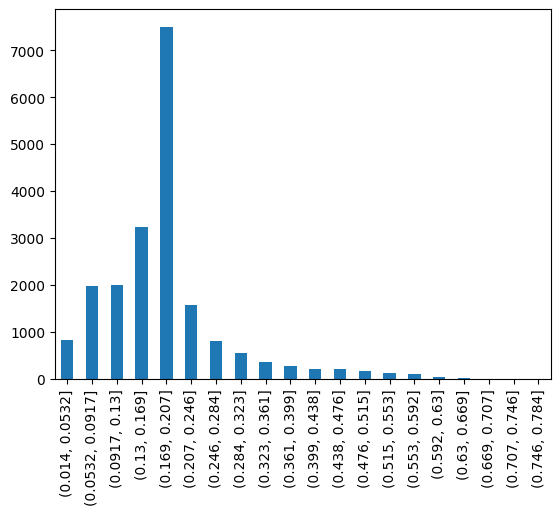

In [39]:
def stat_result(pred):
    ret = pd.DataFrame({'label' : pred})
    df_ret = ret.groupby(pd.cut(pred, bins=20))['label'].agg('count')
    df_ret.plot(kind='bar')
    

# df_ret[[3]]
stat_result(test_test_pred)
# pd.cut(df_ret[3], bins=20)

# LGB MODEL1  指定种子

In [82]:
answers = []
auc_arr = [] 
import random
random.seed(a=10)
sedd_arr = random.sample(range(1,10000), 5)
# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for i, seed in enumerate(sedd_arr):
for seed in  [10, 11, 1989]:
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=seed, shuffle=True)
    #lgb model 
    lgb_clf, test_pred = lgb_feature(X_train, y_train, X_test, y_test)
    train_pred = lgb_clf.predict(X_train)
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('----------------------------- the %d epoch lgb_model valid auc --------------------- ' % i, train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = lgb_clf.predict(X_test_test)
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc describe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

[100]	training's auc: 0.678407	valid_1's auc: 0.666936
[200]	training's auc: 0.69525	valid_1's auc: 0.66809
[300]	training's auc: 0.711577	valid_1's auc: 0.670378
[400]	training's auc: 0.727443	valid_1's auc: 0.671832
[500]	training's auc: 0.742603	valid_1's auc: 0.672062
[600]	training's auc: 0.754129	valid_1's auc: 0.672752
[700]	training's auc: 0.767405	valid_1's auc: 0.672659
[800]	training's auc: 0.777929	valid_1's auc: 0.6734
[900]	training's auc: 0.787718	valid_1's auc: 0.673863
[1000]	training's auc: 0.797312	valid_1's auc: 0.674153
[1100]	training's auc: 0.806258	valid_1's auc: 0.673914
[1200]	training's auc: 0.815365	valid_1's auc: 0.673347
[1300]	training's auc: 0.823445	valid_1's auc: 0.673878
[1400]	training's auc: 0.831077	valid_1's auc: 0.673868
[1500]	training's auc: 0.838315	valid_1's auc: 0.673653
[1600]	training's auc: 0.844752	valid_1's auc: 0.674048
[1700]	training's auc: 0.852143	valid_1's auc: 0.67474
[1800]	training's auc: 0.85786	valid_1's auc: 0.674951
[1900]	

# LGB model1 test_size = 0.1

In [86]:
answers = []
auc_arr = [] 
import random
random.seed(a=10)
sedd_arr = random.sample(range(1,10000), 5)
# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for seed in  [10, 11, 1989]:
for i, seed in enumerate(sedd_arr):
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.1, random_state=seed, shuffle=True)
    #lgb model 
    lgb_clf, test_pred = lgb_feature(X_train, y_train, X_test, y_test)
    train_pred = lgb_clf.predict(X_train)
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('----------------------------- the %d epoch lgb_model valid auc --------------------- ' % i, train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = lgb_clf.predict(X_test_test)
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc describe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

[100]	training's auc: 0.679203	valid_1's auc: 0.653807
[200]	training's auc: 0.694417	valid_1's auc: 0.654399
[300]	training's auc: 0.709002	valid_1's auc: 0.655899
[400]	training's auc: 0.722636	valid_1's auc: 0.656784
[500]	training's auc: 0.734649	valid_1's auc: 0.657503
[600]	training's auc: 0.747498	valid_1's auc: 0.657854
[700]	training's auc: 0.760004	valid_1's auc: 0.658605
[800]	training's auc: 0.770616	valid_1's auc: 0.65899
[900]	training's auc: 0.779914	valid_1's auc: 0.658916
[1000]	training's auc: 0.788272	valid_1's auc: 0.658474
[1100]	training's auc: 0.797283	valid_1's auc: 0.657742
[1200]	training's auc: 0.805969	valid_1's auc: 0.658578
[1300]	training's auc: 0.814643	valid_1's auc: 0.658908
[1400]	training's auc: 0.82179	valid_1's auc: 0.659433
[1500]	training's auc: 0.82881	valid_1's auc: 0.659879
[1600]	training's auc: 0.835806	valid_1's auc: 0.659972
[1700]	training's auc: 0.842795	valid_1's auc: 0.659692
[1800]	training's auc: 0.849006	valid_1's auc: 0.659743
[190

# LGB MODEL1  随机种子

In [83]:
answers = []
auc_arr = [] 
import random
random.seed(a=10)
sedd_arr = random.sample(range(1,10000), 5)
# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for seed in  [10, 11, 1989]:
for i, seed in enumerate(sedd_arr):
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.2, random_state=seed, shuffle=True)
    #lgb model 
    lgb_clf, test_pred = lgb_feature(X_train, y_train, X_test, y_test)
    train_pred = lgb_clf.predict(X_train)
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('----------------------------- the %d epoch lgb_model valid auc --------------------- ' % i, train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = lgb_clf.predict(X_test_test)
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc describe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

[100]	training's auc: 0.681637	valid_1's auc: 0.650021
[200]	training's auc: 0.696665	valid_1's auc: 0.651322
[300]	training's auc: 0.713113	valid_1's auc: 0.651536
[400]	training's auc: 0.729707	valid_1's auc: 0.652245
[500]	training's auc: 0.744224	valid_1's auc: 0.652089
[600]	training's auc: 0.757229	valid_1's auc: 0.65323
[700]	training's auc: 0.768326	valid_1's auc: 0.653753
[800]	training's auc: 0.779889	valid_1's auc: 0.653981
[900]	training's auc: 0.790473	valid_1's auc: 0.654483
[1000]	training's auc: 0.800583	valid_1's auc: 0.654936
[1100]	training's auc: 0.80996	valid_1's auc: 0.655081
[1200]	training's auc: 0.818379	valid_1's auc: 0.655063
[1300]	training's auc: 0.82598	valid_1's auc: 0.654301
[1400]	training's auc: 0.834068	valid_1's auc: 0.654252
[1500]	training's auc: 0.842141	valid_1's auc: 0.653645
[1600]	training's auc: 0.84896	valid_1's auc: 0.653617
[1700]	training's auc: 0.855658	valid_1's auc: 0.653014
[1800]	training's auc: 0.861376	valid_1's auc: 0.653259
[1900

# LGB model2  指定种子

In [74]:
answers = []
auc_arr = [] 

# for seed in  [10, 11, 100, 1000, 2025, 1989]:
for seed in  [10, 11, 1989]:
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.1, random_state=seed, shuffle=True)
    #lgb model 
    lgb_clf, test_pred = lgb_feature2(X_train, y_train, X_test, y_test)
    train_pred = lgb_clf.predict(X_train)
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('----------------------------- lgb_model valid auc --------------------- ', train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = lgb_clf.predict(X_test_test)
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('answers ', np.array(answers).shape)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.659539	valid_1's auc: 0.667848
[200]	training's auc: 0.668736	valid_1's auc: 0.670083
[300]	training's auc: 0.678407	valid_1's auc: 0.674028
[400]	training's auc: 0.6847	valid_1's auc: 0.674625
Early stopping, best iteration is:
[356]	training's auc: 0.681327	valid_1's auc: 0.675241
----------------------------- lgb_model valid auc ---------------------  0.6813268150308923 0.6752413555049274
final pred  [0.12707165 0.06092715 0.18527327 ... 0.18461119 0.18176325 0.19762524]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.659442	valid_1's auc: 0.65961
[200]	training's auc: 0.667148	valid_1's auc: 0.663661
[300]	training's auc: 0.676863	valid_1's auc: 0.669536
[400]	training's auc: 0.683139	valid_1's auc: 0.672334
[500]	training's auc: 0.689672	valid_1's auc: 0.67365
[600]	training's auc: 0.695823	valid_1's auc: 0.673289
Early stopping, best iteration is:
[518]	trai

#  LGB feature2随机种子

In [79]:
answers = []
auc_arr = [] 
import random
random.seed(a=10)
sedd_arr = random.sample(range(1,10000), 5)
# for seed in  [10, 11, 100, 1000, 2025, 1989]:
# for seed in  [10, 11, 1989]:
for i, seed in enumerate(sedd_arr):
    X_train, X_test, y_train, y_test = train_test_split(X_train_train, y_train_train, test_size=0.1, random_state=seed, shuffle=True)
    #lgb model 
    lgb_clf, test_pred = lgb_feature2(X_train, y_train, X_test, y_test)
    train_pred = lgb_clf.predict(X_train)
    # train auc, test auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('----------------------------- the %d epoch lgb_model valid auc --------------------- ' % i, train_auc, test_auc)
    auc_arr.append((train_auc, test_auc))
    #最终输出
    final_pred = lgb_clf.predict(X_test_test)
    print('final pred ',final_pred)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr, columns=['train auc', 'test_auc']))
print('auc describe \n', pd.DataFrame(auc_arr).describe())
print('answers ', np.array(answers).shape)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.661348	valid_1's auc: 0.649421
[200]	training's auc: 0.670372	valid_1's auc: 0.651463
[300]	training's auc: 0.677503	valid_1's auc: 0.655337
[400]	training's auc: 0.684539	valid_1's auc: 0.655699
[500]	training's auc: 0.690945	valid_1's auc: 0.656484
[600]	training's auc: 0.696829	valid_1's auc: 0.656887
[700]	training's auc: 0.702319	valid_1's auc: 0.657716
[800]	training's auc: 0.707166	valid_1's auc: 0.657806
[900]	training's auc: 0.71201	valid_1's auc: 0.65825
[1000]	training's auc: 0.716138	valid_1's auc: 0.658093
Early stopping, best iteration is:
[904]	training's auc: 0.712131	valid_1's auc: 0.658296
----------------------------- the 0 epoch lgb_model valid auc ---------------------  0.712131483763858 0.658296136553166
final pred  [0.09567222 0.05080067 0.15231508 ... 0.17279651 0.17972776 0.18853596]
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.660422	v

In [76]:
#保存结果
df_ans = pd.DataFrame(answers).T
df_ans['label'] = df_ans.mean(axis = 1)
df_ans['id'] = pd.DataFrame({'id':X_test_test.index.values})[['id']]
print('df_ans \n',df_ans)
df_out = df_ans[['id','label']]
print('df_out \n',df_out)
df_out.to_csv('%s_gh_lgb_kfold_v1.csv' % suffix, encoding='utf-8', index=False, mode='w')
df_ans.to_csv('%s_gh_lgb_kfold_v1_answers.txt' % suffix, encoding='utf-8', index=False, mode='w')
!ls

df_ans 
               0         1         2     label     id
0      0.127072  0.117132  0.115201  0.119801  53480
1      0.060927  0.060430  0.053903  0.058420  53481
2      0.185273  0.167918  0.145114  0.166102  53482
3      0.242786  0.235228  0.245334  0.241116  53483
4      0.117751  0.115344  0.112703  0.115266  53484
...         ...       ...       ...       ...    ...
20049  0.185612  0.185762  0.188441  0.186605  73529
20050  0.118680  0.111380  0.109775  0.113278  73530
20051  0.184611  0.176939  0.183426  0.181659  73531
20052  0.181763  0.179775  0.181118  0.180885  73532
20053  0.197625  0.190997  0.197406  0.195343  73533

[20054 rows x 5 columns]
df_out 
           id     label
0      53480  0.119801
1      53481  0.058420
2      53482  0.166102
3      53483  0.241116
4      53484  0.115266
...      ...       ...
20049  73529  0.186605
20050  73530  0.113278
20051  73531  0.181659
20052  73532  0.180885
20053  73533  0.195343

[20054 rows x 2 columns]
202508261937_gh_lg

# LGB feature2 STRatifiedKFold

In [71]:
n_folds = 10
answers = []
auc_arr = [] 

sk = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=10)
y_train_train = pd.DataFrame(y_train_train)
for train, test in sk.split(X_train_train, y_train_train):
    X_train = X_train_train.iloc[train]
    y_train = y_train_train.iloc[train]
    X_test  = X_train_train.iloc[test]
    y_test  = y_train_train.iloc[test]
    lgb_clf, test_pred = lgb_feature2(X_train, y_train, X_test, y_test)
    train_pred = lgb_clf.predict(X_train)
    # 记录训练集auc, 测试集auc
    train_auc = roc_auc_score(y_train, train_pred)
    test_auc  = roc_auc_score(y_test, test_pred)
    print('--------------lgb_model valid auc ------------- ', train_auc, test_auc)
    auc_arr.append((train_auc,test_auc))
    #最终输出
    final_pred = lgb_clf.predict(X_test_test)
    answers.append(final_pred)
print('auc arr \n', pd.DataFrame(auc_arr))
print('auc arr describe \n', pd.DataFrame(auc_arr).describe())

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.660023	valid_1's auc: 0.655701
Early stopping, best iteration is:
[59]	training's auc: 0.657019	valid_1's auc: 0.657069
--------------lgb_model valid auc -------------  0.6570193659269206 0.6570693505552871
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.660647	valid_1's auc: 0.646978
Early stopping, best iteration is:
[5]	training's auc: 0.649598	valid_1's auc: 0.648634
--------------lgb_model valid auc -------------  0.6495979448672948 0.6486344157411879
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.66119	valid_1's auc: 0.664896
Early stopping, best iteration is:
[74]	training's auc: 0.658964	valid_1's auc: 0.665616
--------------lgb_model valid auc -------------  0.658963964448689 0.6656163427433357
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.660715	valid_1's auc: 0.657629
[200]	t

## 全量训练并预测

In [164]:
train_data = pd.read_csv(train_dat_path, engine = 'python');
train_data = train_data.fillna(0)

test_data = pd.read_csv(test_dat_path, engine = 'python');
test_data = test_data.fillna(0)

train_test_data = pd.concat([train_data, test_data], axis=0, ignore_index = True)
train_test_data.drop([ 'tx_time_max', 'tx_time_min'], axis = 1, inplace=True)

train_test_data = train_test_data.fillna(0)
train_test_data.replace([np.inf, -np.inf], 0, inplace=True)

dummy_df = pd.get_dummies(train_test_data.loc[:,dummy_fea])
train_test_data = pd.concat([train_test_data, dummy_df], axis=1)
train_test_data = train_test_data.drop(dummy_fea, axis=1)
print(train_test_data)

train_train = train_test_data.iloc[:train_data.shape[0],:]
test_test = train_test_data.iloc[train_data.shape[0]:,:]

y_train = train_train['label'].values
X_train = train_train.drop(['label'],axis=1)
y_test  = test_test['label'].values
X_test  = test_test.drop(['label'],axis=1)


        loan  term  interest_rate  issue_time  record_time  history_time  \
0       7200    36          10.95  1238631967   1238630622     472006661   
1      21300    36          12.95  1128212052   1161907665     763779041   
2      10400    60          21.05  1249171509   1383958593     727143443   
3      33050    36          16.40  1172882234   1214353935     687660346   
4       5200    36          14.35  1172882384   1240274527     322012875   
...      ...   ...            ...         ...          ...           ...   
73529  10000    12          18.85  1130976000   1125964800    1018224000   
73530  10000    12          29.30  1156204800   1157068800    1054425600   
73531  11000    12          24.75  1144108800   1111622400    1037404800   
73532   8000    12          22.00  1163808000   1116892800    1057017600   
73533   7000    12          14.95  1188777600   1146614400    1047600000   

       total_accounts  balance_accounts  balance_limit   balance  ...  \
0             

In [176]:
lgb_clf, test_pred = lgb_feature(X_train, y_train, X_test, y_test)

[50]	training's auc: 0.663415	valid_1's auc: 1
[100]	training's auc: 0.673025	valid_1's auc: 1
[150]	training's auc: 0.680781	valid_1's auc: 1
[200]	training's auc: 0.687596	valid_1's auc: 1
[250]	training's auc: 0.693334	valid_1's auc: 1
[300]	training's auc: 0.699535	valid_1's auc: 1
[350]	training's auc: 0.704562	valid_1's auc: 1
[400]	training's auc: 0.711469	valid_1's auc: 1
[450]	training's auc: 0.71822	valid_1's auc: 1
[500]	training's auc: 0.724208	valid_1's auc: 1
[550]	training's auc: 0.728805	valid_1's auc: 1
[600]	training's auc: 0.733599	valid_1's auc: 1
[650]	training's auc: 0.739301	valid_1's auc: 1
[700]	training's auc: 0.743708	valid_1's auc: 1
[750]	training's auc: 0.748405	valid_1's auc: 1
[800]	training's auc: 0.752436	valid_1's auc: 1
[850]	training's auc: 0.757244	valid_1's auc: 1
[900]	training's auc: 0.761069	valid_1's auc: 1
[950]	training's auc: 0.765553	valid_1's auc: 1
[1000]	training's auc: 0.769174	valid_1's auc: 1
[1050]	training's auc: 0.773951	valid_1's

20054

In [20]:
df_ans = pd.DataFrame(test_pred).T
print('df_ans shape : ', df_ans.shape)
df_ans['label'] = df_ans.mean(axis = 1)
print(df_ans)
df_ans['id']  = X_test_test.reset_index().rename(columns={'index':'id'})['id']
print(df_ans)
df_ans[['id','label']].to_csv('%s_gh_lgb_kfold_v1.csv' % suffix, encoding='utf-8', index=False, mode='w')
df_ans.to_csv('%s_gh_lgb_kfold_v1_full.txt' % suffix, encoding='utf-8', index=False, mode='w')
!ls

(20054, 1)
202508261937_gh_lgb_v3.csv
202508261937_gh_v1.csv
202508261937_gh_v2.csv
model_stacking_v5.0.ipynb
model_stacking_v5.1.ipynb
model_stacking_v5.ipynb
process_v5.ipynb
test.dat.202508261937
train.dat.202508261937


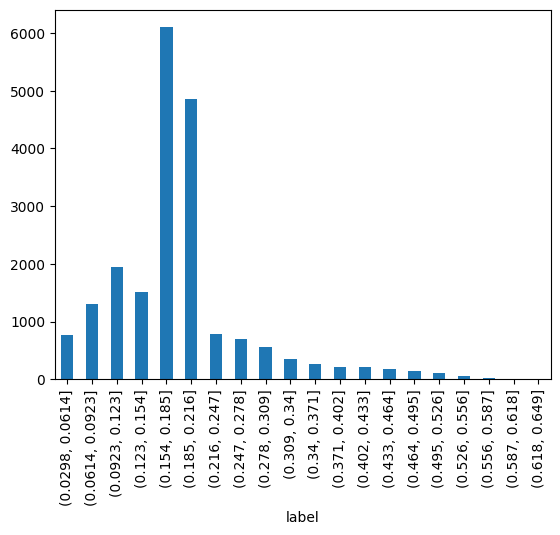

In [72]:
def stat_file_result(file_input):
    ret = pd.read_csv(file_input)
    df_ret = ret.groupby(pd.cut(ret['label'],bins=20))['label'].agg('count')
#     print(df_ret)
    df_ret.plot(kind='bar')
stat_file_result('202508261937_gh_lgb_kfold_v1.csv')


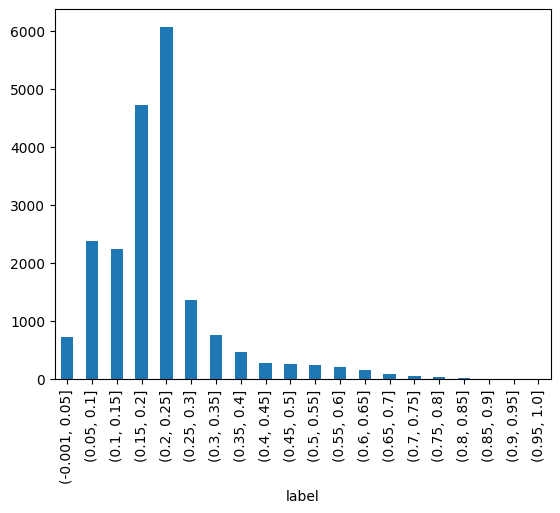

In [24]:
stat_file_result('202508261937_gh_v2.csv')

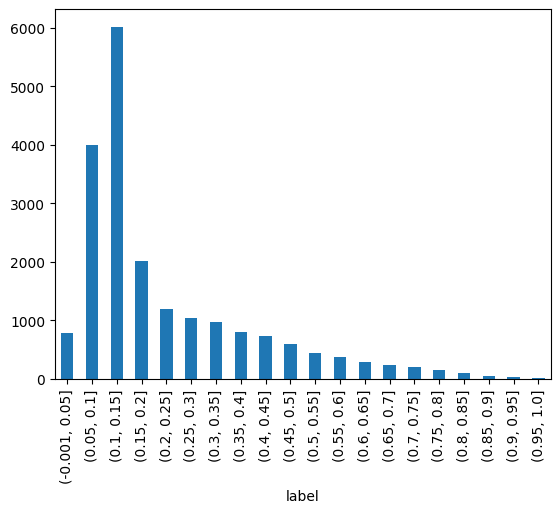

In [25]:
stat_file_result('202508261937_gh_lgb_v3.csv')